# Построение классификатора диабета у пациента

## Задание 1. Подготовка и анализ данных

### Задание 1.1

Окружение 

In [148]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Для разделения данных и мастшабирования 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler 

# Модели и метрики 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve

#Настройка отображения графиков 
%matplotlib inline
sns.set(style='whitegrid', context='notebook')

In [63]:
df = pd.read_csv("diabetes.csv")
df.head()

# Целевая переменная
TARGET_COLUMN = 'Outcome'
# Признаки для анализа
feature_columns = df.columns.drop(TARGET_COLUMN)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [67]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Пропусков  нету, двиагаемся дальше! 

In [25]:
df.duplicated().sum()

0

________________________________________________________________________________________________________________________________________________________

**Первичный анализ данных**: Мы имеем табличный датасет о заболеваемости диабетом девушек Датасет содержит следующие поля:

**Pregnancies** - беременость , немного не понимаю в чем суть этого столбца и чем являются цифры. Предположу, что это статус беремености n = 0 - нету. n => 1 - есть.

**Glucose** - уровень глюкозы в крови. Скорее всего измерялся в мг/дл. Норма натощак 79-110 . После еды до 140 мг/дл. В некоторых случаях глюкоза не измерлась

**BloodPressure** - кровяное давление. Измеряется в мм.рт.ст . Норма 120 - КСД / 80 - КДД. В некоторых случаях АД не измерялось

**SkinThickness** - толщина кожи

**Insulin** - кол-во инсулина в крови Норма 2,6 - 24,9 мкЕд/мл. В некоторых случаях не измерялось

**BMI** - ИМТ. Норма ИМТ 18,5–24,9 кг/м².

**DiabetesPedigreeFunction** - Функция родословности диабета, наследственное значение диабета

**Age** - возраст

**Outcome** - целевой признак (Outcome), где Outcome=1 означает наличие диабета, а Outcome=0 — его отсутствие.



**Замена некорректных нулей на NaN**

Это важный шаг перед дальнейшим анализом, так как нули исказят распределения и статистики.

In [35]:
print("\nОбработка некорректных нулей:")
cols_with_zeros_as_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros_as_missing] = df[cols_with_zeros_as_missing].replace(0, np.nan)

print("Количество нулей после замены в этих колонках:")
for col in cols_with_zeros_as_missing:
    print(f"{col}: {(df[col] == 0).sum()}")

# Теперь снова проверим пропуски


Обработка некорректных нулей:
Количество нулей после замены в этих колонках:
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0


 **Изучение наличия пропусков (после замены нулей)**


2. Анализ пропусков (после замены нулей):
               Count  Percentage
Insulin          374   48.697917
SkinThickness    227   29.557292
BloodPressure     35    4.557292
BMI               11    1.432292
Glucose            5    0.651042


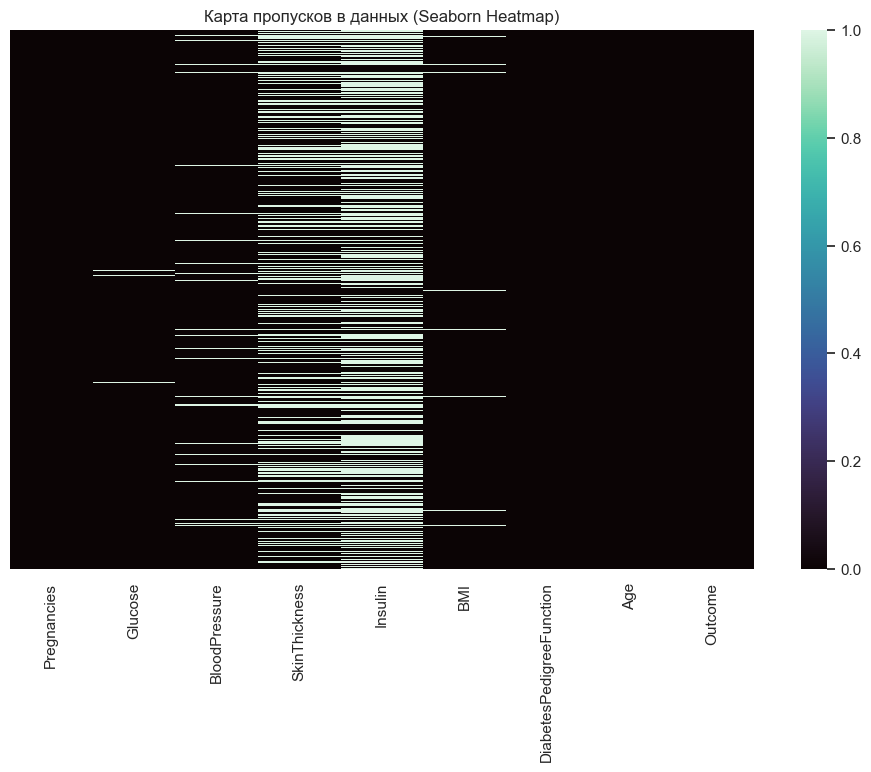

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10148\4044338163.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_info[missing_info['Count'] > 0].index,


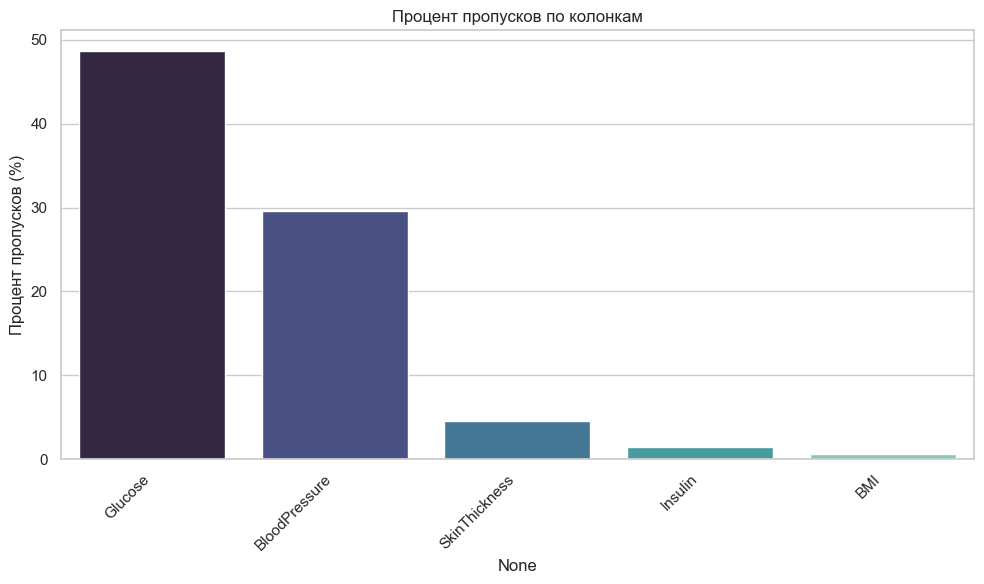

In [52]:
print("\n2. Анализ пропусков (после замены нулей):")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percentage})
print(missing_info[missing_info['Count'] > 0].sort_values(by='Percentage', ascending=False))

# Визуализация пропусков с использованием heatmap от seaborn
plt.figure(figsize=(12, 7))
sns.heatmap(df.isnull(), cbar=True, cmap='mako', yticklabels=False,) # yticklabels=False если строк много
plt.title('Карта пропусков в данных (Seaborn Heatmap)')
plt.show()

# Альтернативная визуализация пропусков (bar plot) с seaborn
if missing_info[missing_info['Count'] > 0].shape[0] > 0:
    plt.figure(figsize=(10,6))
    sns.barplot(x=missing_info[missing_info['Count'] > 0].index, 
                y='Percentage', 
                data=missing_info[missing_info['Count'] > 0].sort_values(by='Percentage', ascending=False),
                palette='mako')
    plt.xticks(rotation=45, ha='right')
    plt.title('Процент пропусков по колонкам')
    plt.ylabel('Процент пропусков (%)')
    plt.tight_layout()
    plt.show()
else:
    print("Пропусков не найдено после обработки нулей.")

**Анализ выбросов, аномалий и распределений**


4. Анализ выбросов, аномалий и распределений:

--- Анализ признака: Pregnancies ---


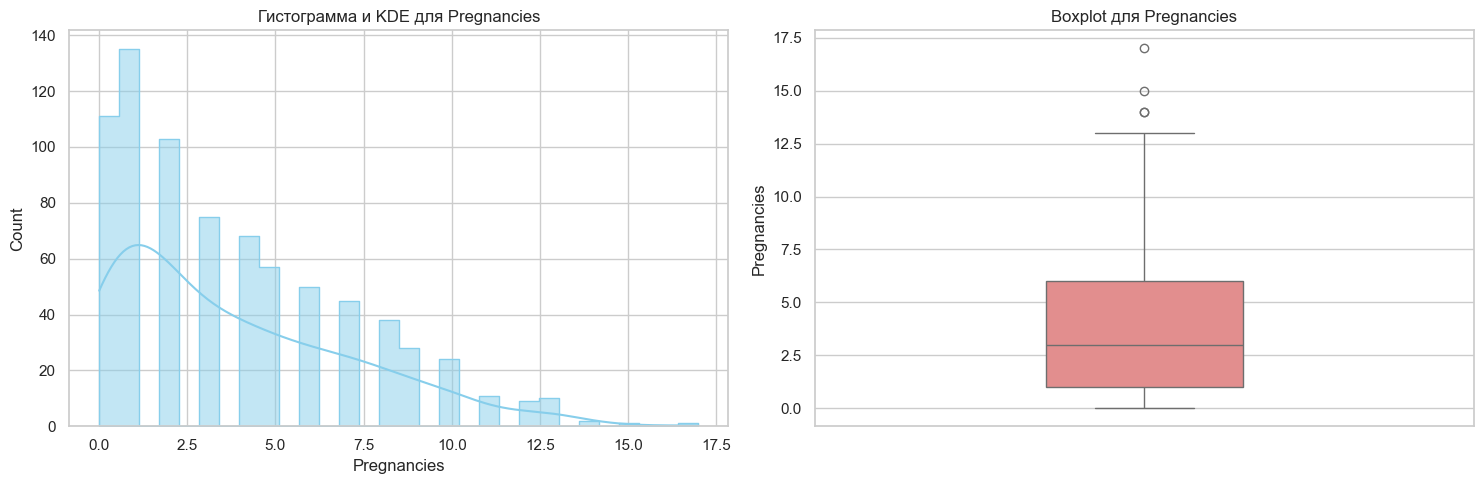

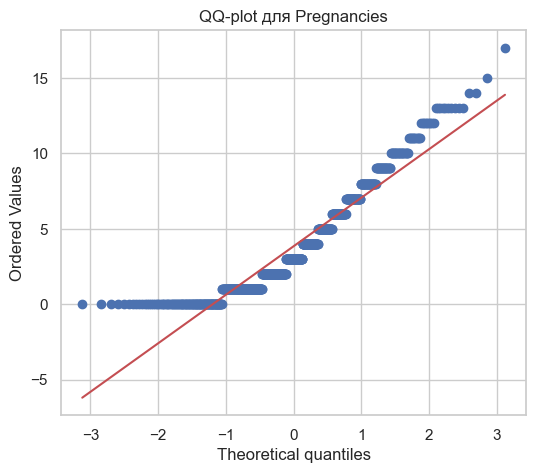

Статистики для Pregnancies (после обработки нулей):
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64
  Асимметрия (skewness): 0.90
  Эксцесс (kurtosis): 0.16

--- Анализ признака: Glucose ---


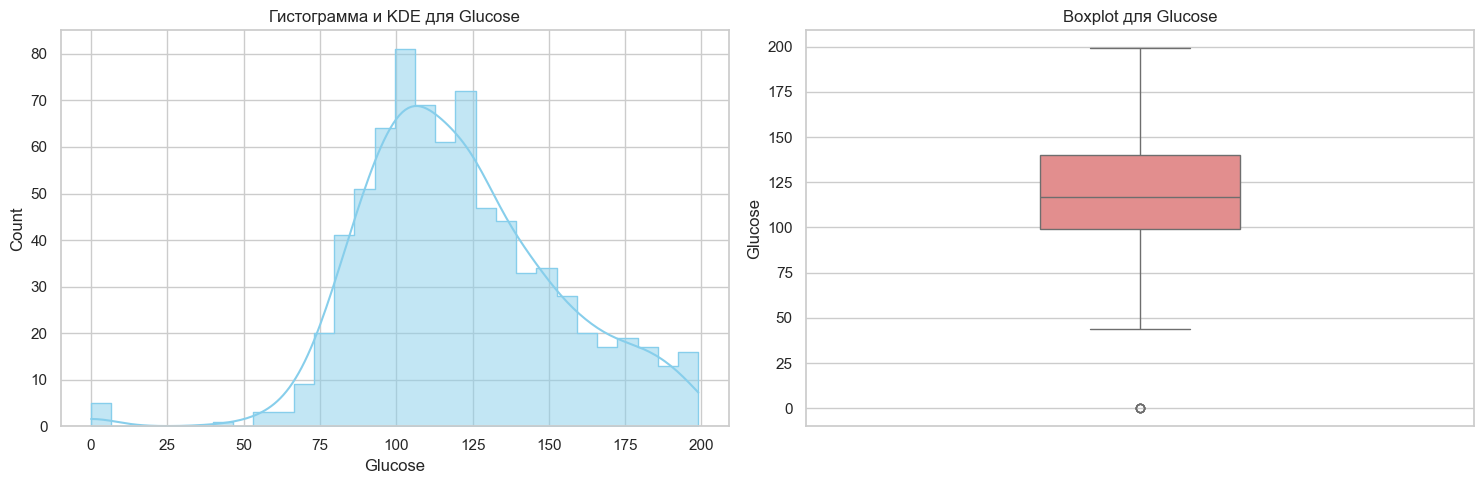

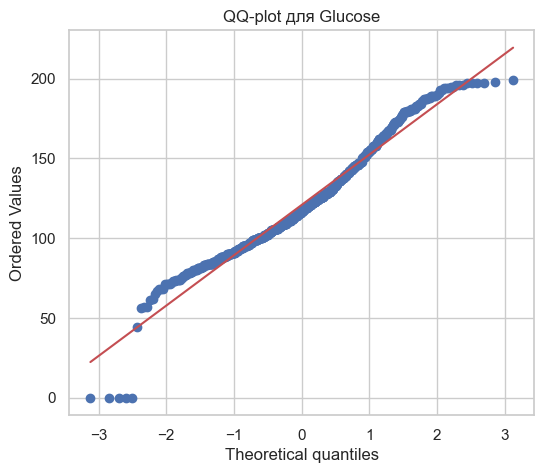

Статистики для Glucose (после обработки нулей):
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64
  Асимметрия (skewness): 0.17
  Эксцесс (kurtosis): 0.64

--- Анализ признака: BloodPressure ---


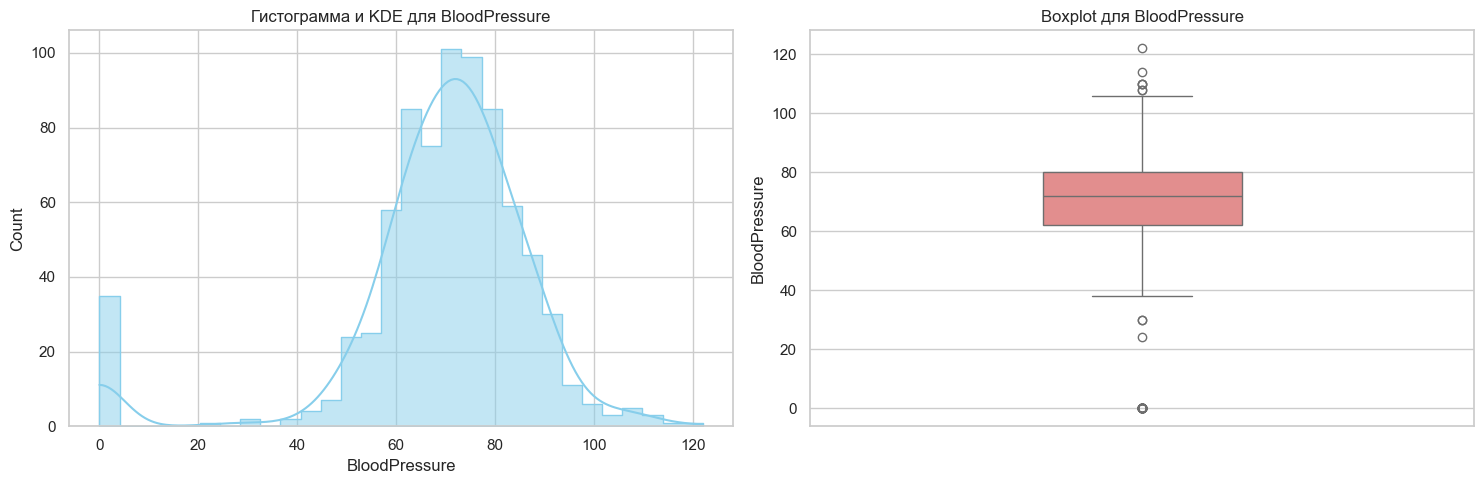

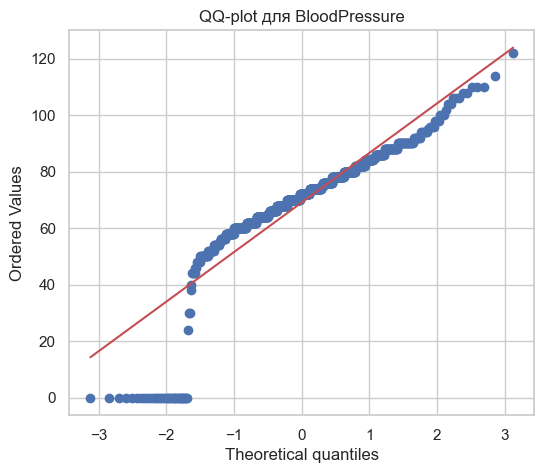

Статистики для BloodPressure (после обработки нулей):
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64
  Асимметрия (skewness): -1.84
  Эксцесс (kurtosis): 5.18

--- Анализ признака: SkinThickness ---


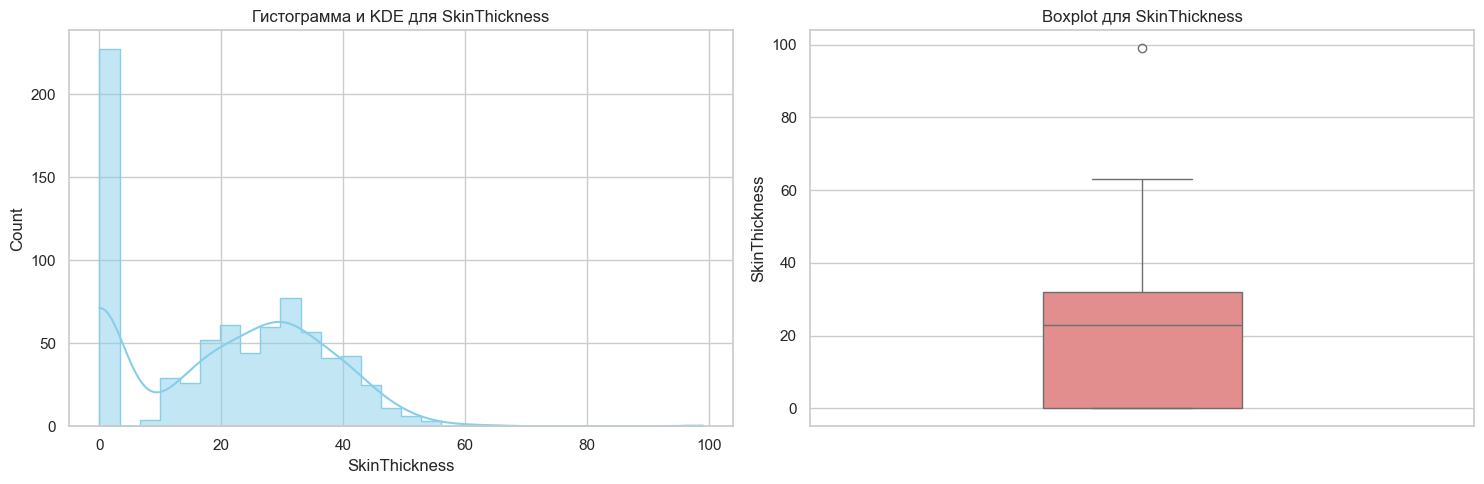

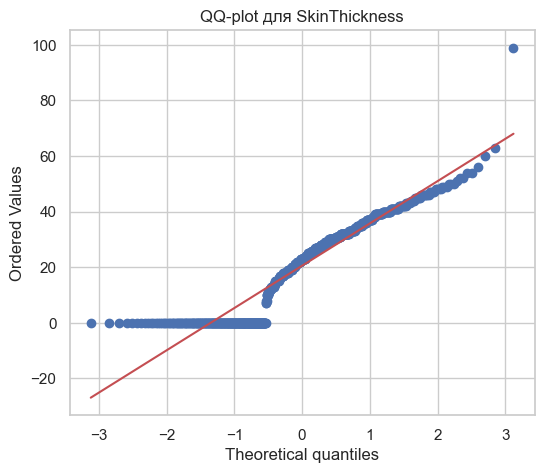

Статистики для SkinThickness (после обработки нулей):
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64
  Асимметрия (skewness): 0.11
  Эксцесс (kurtosis): -0.52

--- Анализ признака: Insulin ---


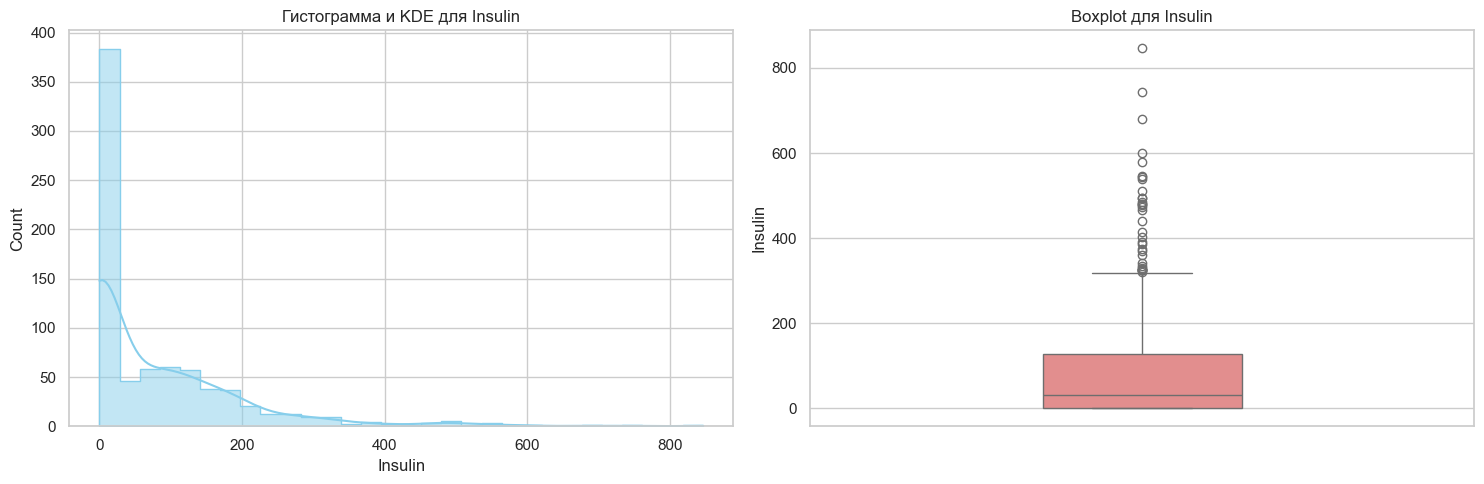

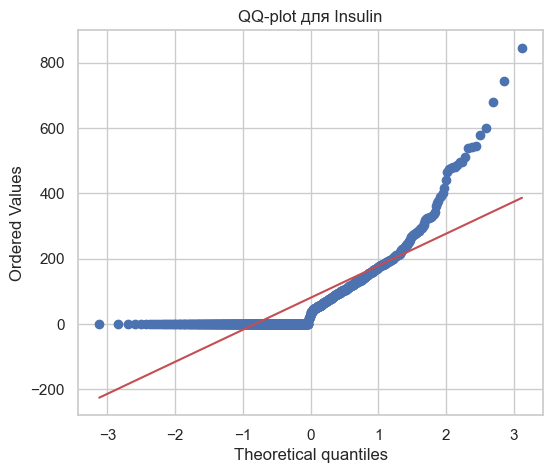

Статистики для Insulin (после обработки нулей):
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64
  Асимметрия (skewness): 2.27
  Эксцесс (kurtosis): 7.21

--- Анализ признака: BMI ---


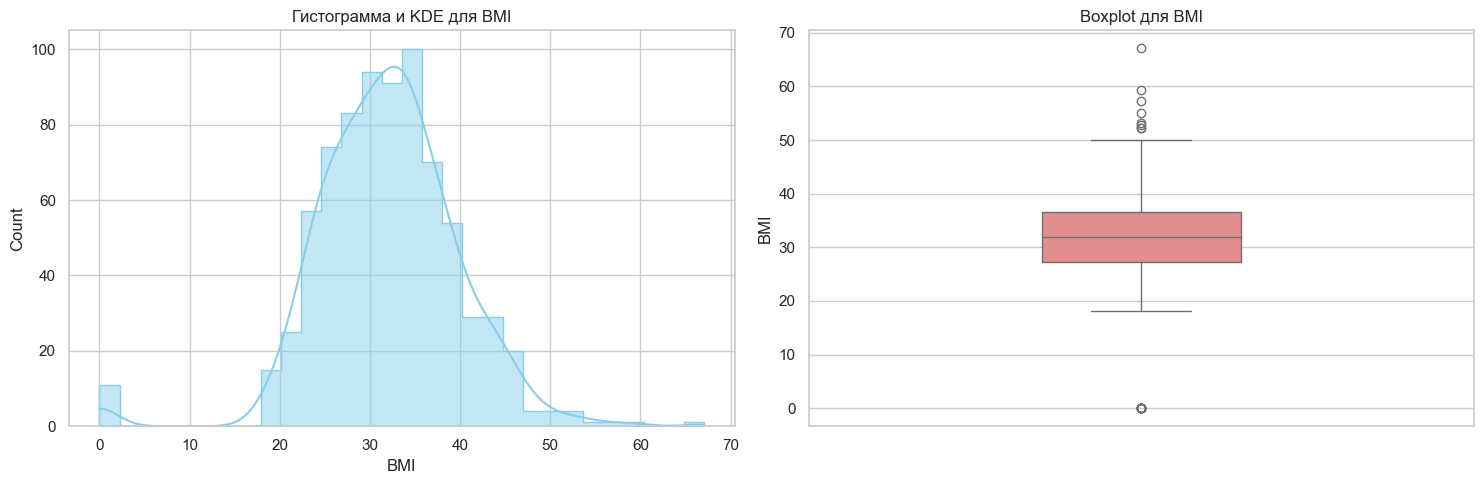

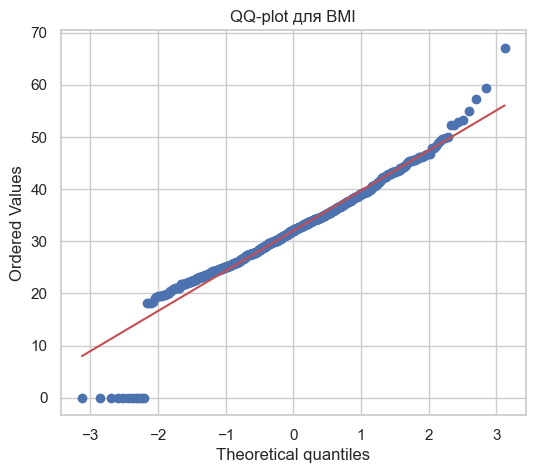

Статистики для BMI (после обработки нулей):
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64
  Асимметрия (skewness): -0.43
  Эксцесс (kurtosis): 3.29

--- Анализ признака: DiabetesPedigreeFunction ---


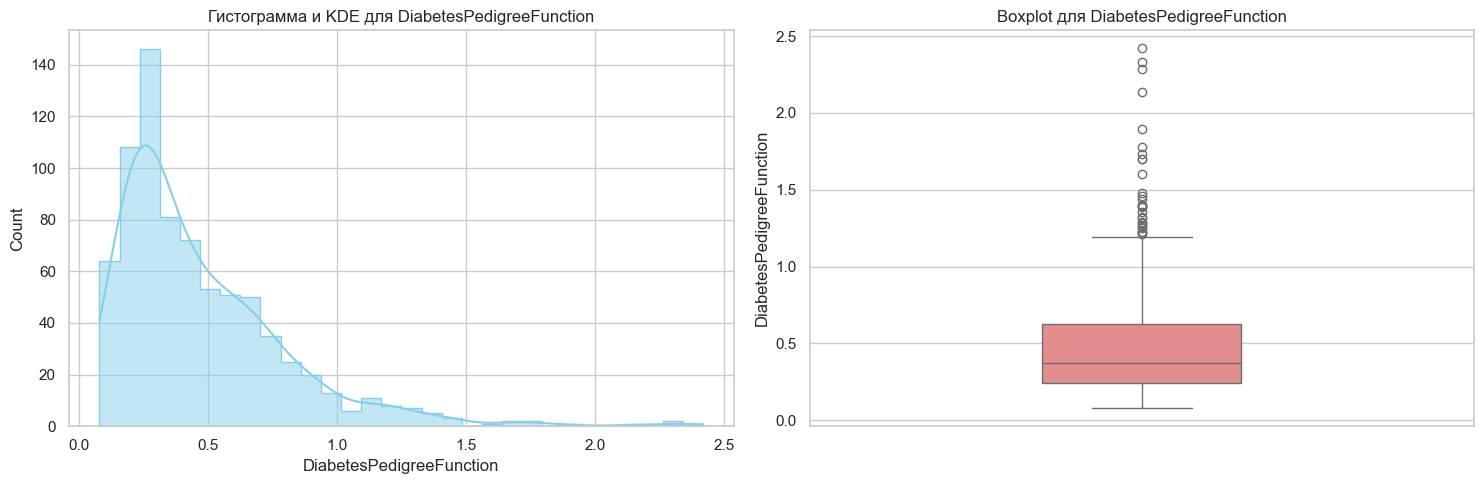

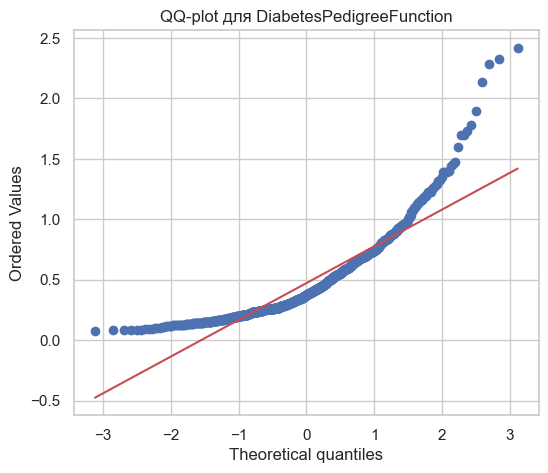

Статистики для DiabetesPedigreeFunction (после обработки нулей):
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64
  Асимметрия (skewness): 1.92
  Эксцесс (kurtosis): 5.59

--- Анализ признака: Age ---


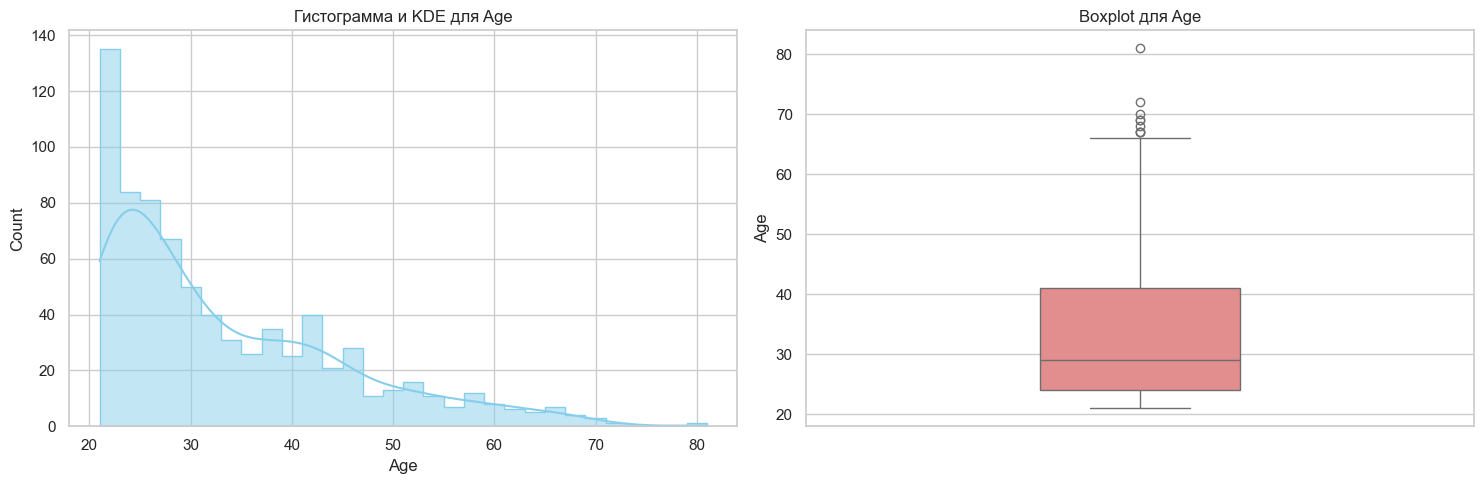

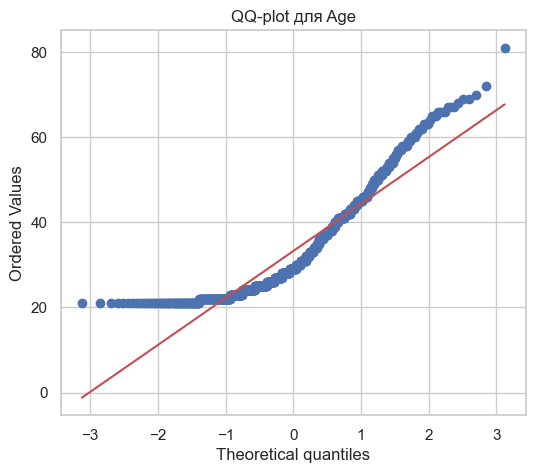

Статистики для Age (после обработки нулей):
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64
  Асимметрия (skewness): 1.13
  Эксцесс (kurtosis): 0.64


In [84]:
print("\n4. Анализ выбросов, аномалий и распределений:")

for col in feature_columns:
    print(f"\n--- Анализ признака: {col} ---")
    
    # Figure-level функция displot для гистограммы и KDE
    # g = sns.displot(df, x=col, kde=True, height=4, aspect=1.5, color='steelblue')
    # g.set_titles(f"Распределение {col}")
    # plt.show()

    # Для лучшего контроля над subplot'ами, можно использовать axes-level функции histplot и kdeplot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(df[col], kde=True, ax=axes[0], color='skyblue', bins=30, element="step")
    axes[0].set_title(f'Гистограмма и KDE для {col}')
    
    sns.boxplot(y=df[col], ax=axes[1], color='lightcoral', width=0.3)
    axes[1].set_title(f'Boxplot для {col}')
    
    plt.tight_layout()
    plt.show()
    
    # QQ-plot (не является функцией seaborn, но важен для оценки нормальности)
    # Оставляем его, если scipy доступен
    try:
        import scipy.stats as stats
        plt.figure(figsize=(6,5))
        stats.probplot(df[col].dropna(), dist="norm", plot=plt)
        plt.title(f'QQ-plot для {col}')
        plt.show()
    except ImportError:
        print(f"Scipy не установлен, QQ-plot для {col} не построен.")

    print(f"Статистики для {col} (после обработки нулей):")
    print(df[col].describe())
    print(f"  Асимметрия (skewness): {df[col].skew():.2f}")
    print(f"  Эксцесс (kurtosis): {df[col].kurtosis():.2f}")

**Попарное сравнение и Корреляция**

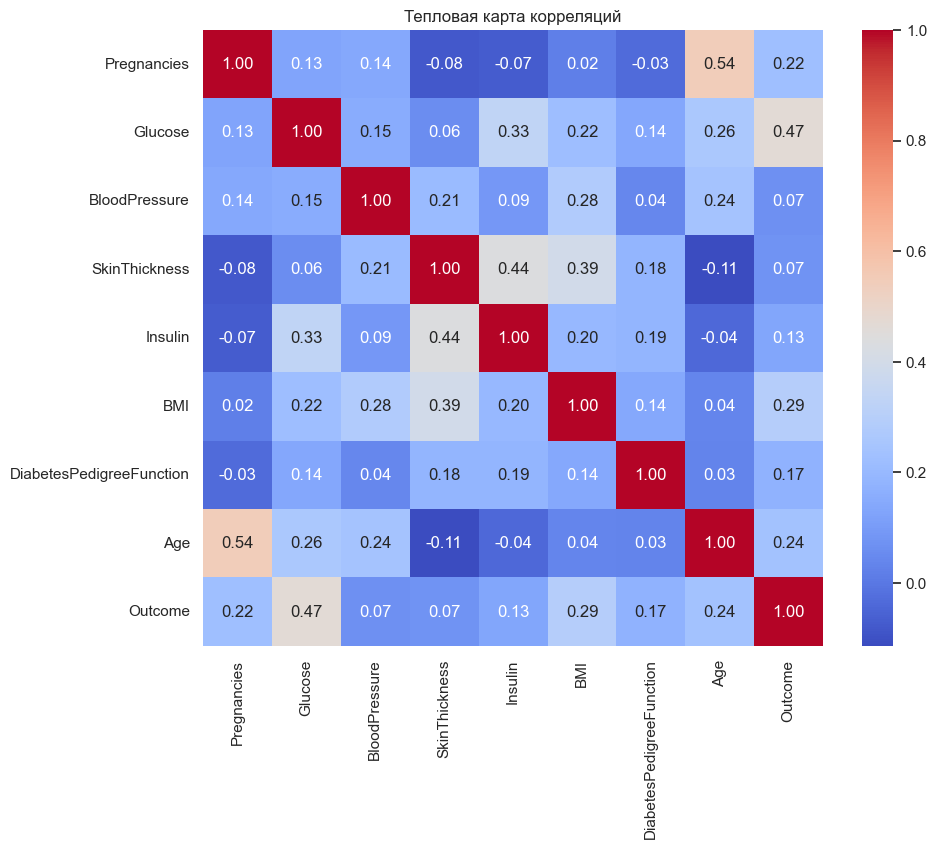

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [87]:
corr_matrix = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot = True, fmt=".2f", cmap="coolwarm")
plt.title("Тепловая карта корреляций")
plt.show()

print(corr_matrix['Outcome'].sort_values(ascending=False))

**Что такое корреляция?** Корреляция измеряет степень и направление взаимосвязи между двумя переменными. Основные моменты:

Значения коэффициента корреляции могут варьироваться от -1 до +1:

+1 означает полную положительную корреляцию (при увеличении одной переменной другая увеличивается пропорционально). -1 означает полную отрицательную корреляцию (при увеличении одной переменной другая уменьшается пропорционально). 0 говорит об отсутствии линейной зависимости между переменными. Положительная корреляция: если две переменные растут вместе (например, с повышением уровня глюкозы может увеличиваться риск развития диабета).

Отрицательная корреляция: если одна переменная растёт, а другая уменьшается (например, при некоторых наборах данных увеличение физической активности может снижать риск развития диабета).

**Интерпретация результатов корреляционного анализа** На что обратить внимание: Сильная корреляция между признаками: Если два признака имеют высокий коэффициент корреляции (например, > 0,7 или < -0,7), это может указывать на то, что они предоставляют схожую информацию. В моделях может возникнуть проблема мультиколлинеарности, которую следует учитывать при построении прогностических моделей.

Корреляция с целевым признаком: Особое внимание уделяется признакам, которые коррелируют с целевой переменной (например, наличием диабета). Например, если Glucose имеет высокую положительную корреляцию с Outcome, то повышение уровня глюкозы, вероятно, связано с повышенным риском развития диабета.

Отрицательные корреляции: Если признак коррелирует с целевым признаком отрицательно, это означает, что увеличение этого признака может быть связано с пониженной вероятностью наступления события (например, наличия заболевания).

Отсутствие корреляции: Низкие коэффициенты корреляции (близкие к 0) указывают на слабую или отсутствующую линейную зависимость. Однако стоит помнить, что между переменными может быть нелинейная зависимость, которую не выявит коэффициент Пирсона.

**В нашем случае следующие признаки сильно коррелируют с Outcome: Glucosa, BMI, Age, Pregnancies**

Построим парные графики для этих данных

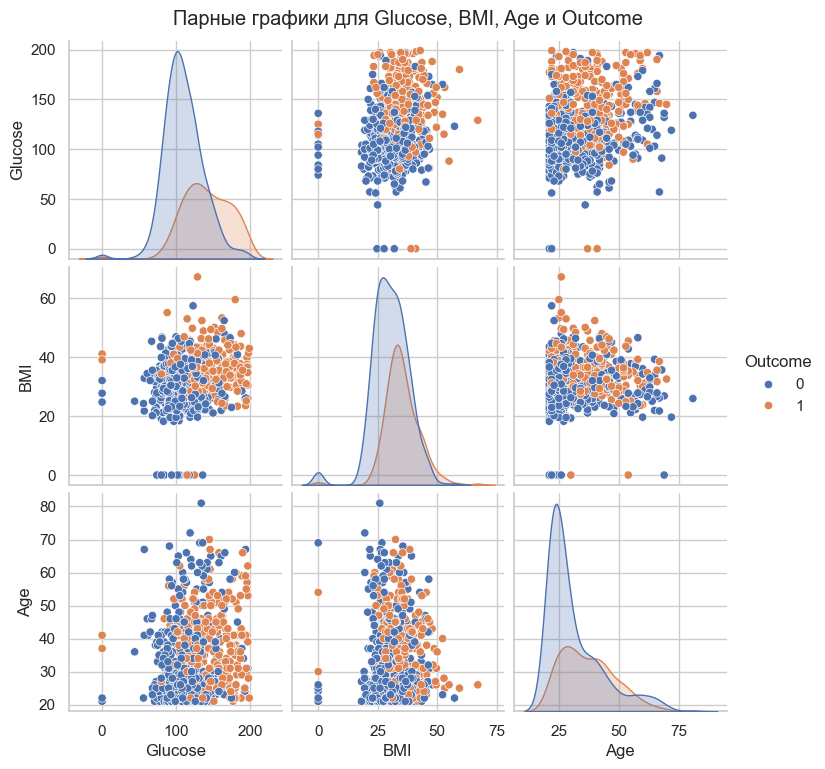

In [97]:
# Для парных графиков выберем наиболее значимые признаки по корреляционному анализу.
# Например, выберем 'Glucose', 'BMI', 'Age' и 'Outcome'
sns.pairplot(df[['Glucose', 'BMI', 'Age', 'Outcome']], hue='Outcome', diag_kind='kde')
plt.suptitle("Парные графики для Glucose, BMI, Age и Outcome", y=1.02)
plt.show()

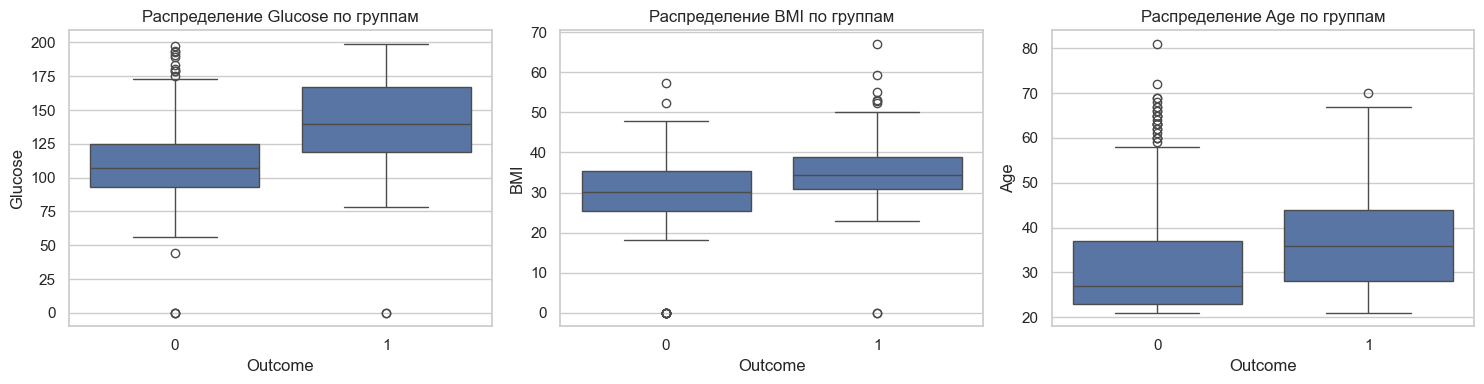

In [100]:
features_to_plot = ['Glucose', 'BMI', 'Age']
plt.figure(figsize=(15,4))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, len(features_to_plot), i+1)
    sns.boxplot( x = 'Outcome', y = feature, data = df)
    plt.title(f"Распределение {feature} по группам")
plt.tight_layout()
plt.show()

**Пояснения: В нашем случае следующие признаки сильно коррелируют с Outcome: Glucosa, BMI, Age, Pregnancies**

В нашем случае следующие признаки имеют слабую корреляцию с Outcome: Insulin, SkinThickness, BloodPressure

Средняя корреляция характерна для DiabetesPedigreeFunction

**Сахарный диабет** — группа эндокринных заболеваний, связанных с нарушением усвоения глюкозы вследствие абсолютной или относительной недостаточности гормона инсулина. В результате развивается гипергликемия — стойкое увеличение содержания глюкозы в крови.

**Соответсвено:**

Глюкоза ключевой фактор в формировании диабет, т.к непосредсвтенно инсулинозависимый/независимый транспорт глюкозы в ткань и будет формировать диабет.
ИМТ - индекс массы тела. При высоком содержании адипоцитов , будет гиперсекреция и гиперпродукция лептина, который будет способстовать пищевому поведению, оказывая восходящие активрующие влияния на подкорковые и корковые представительства . Пищевое поведение сулит повышенное содержение глюкозы в крови
Возраст - старость настпуает с 60 лет, соотвествено все процессы жизнедеятльности будут приходить в упадок
Беременость - кординальное изменениние женского организма, гормональные изменения.

Соответвено, низкая корреляция:

1.Инсулин - естб диабет двух типов инсулинозависимый и независыимый ( соотвествено первый и второй тип) и при инсулинонезависимом диабете, корреляция инсулина с Outcome будет очень низкая.

2.Толщина кожи имеет связь с ИМТ. Т.к напрямую связана с ПЖК.

3.Кровяное давление - Слабая первостепенная связь с диабетом. Хотя имеется выоская корреляция к ИМТ. ( При росте ИМТ, АД увеличивается)

________________________________________________________________________________________________________________________________________________________

**Сравнение распределения по колонкам у разных классов целевого признака.**


6. Сравнение распределений признаков по классам целевого признака 'Outcome':

--- Сравнение распределений для: Pregnancies по Outcome ---


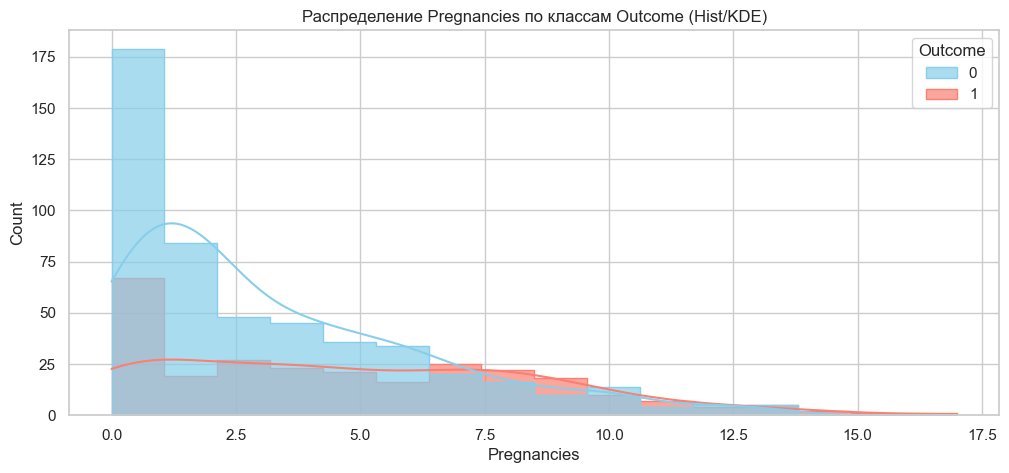


--- Сравнение распределений для: Glucose по Outcome ---


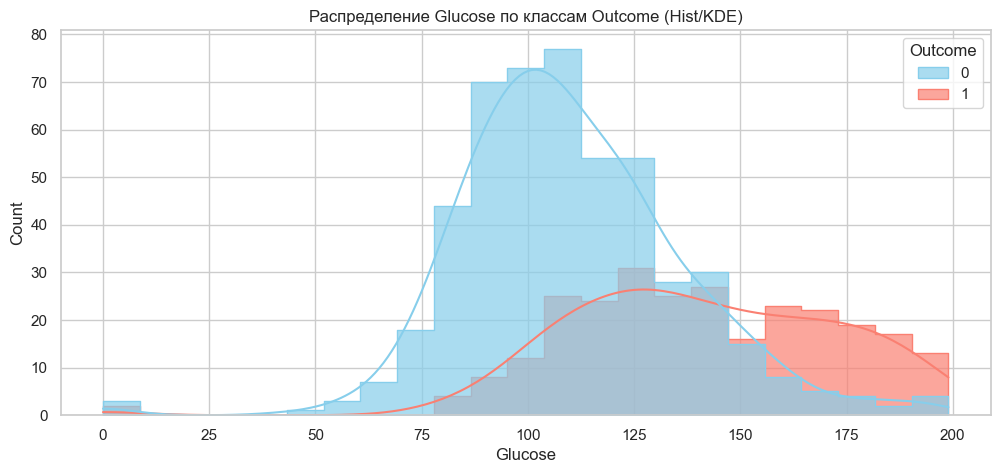


--- Сравнение распределений для: BloodPressure по Outcome ---


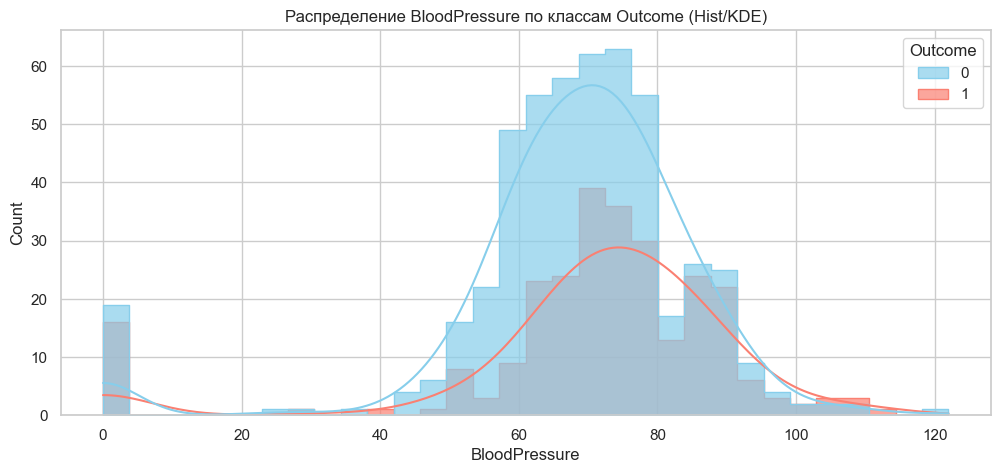


--- Сравнение распределений для: SkinThickness по Outcome ---


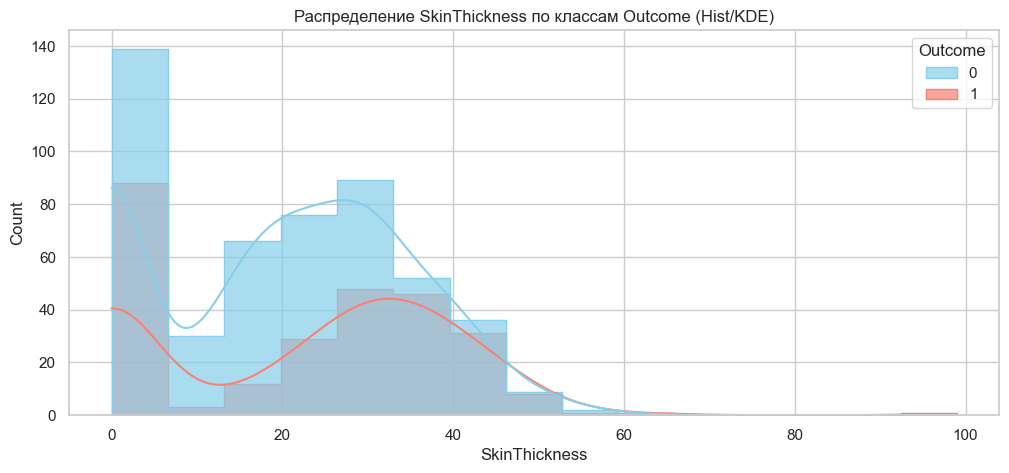


--- Сравнение распределений для: Insulin по Outcome ---


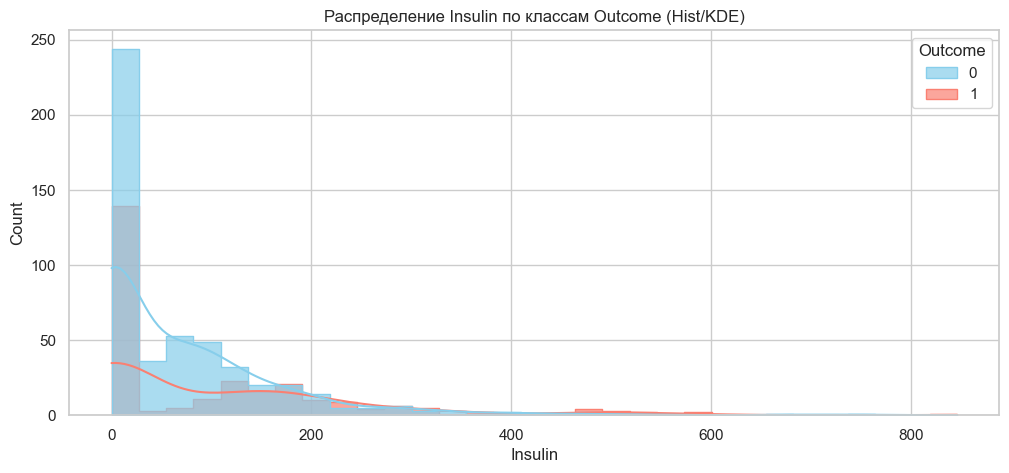


--- Сравнение распределений для: BMI по Outcome ---


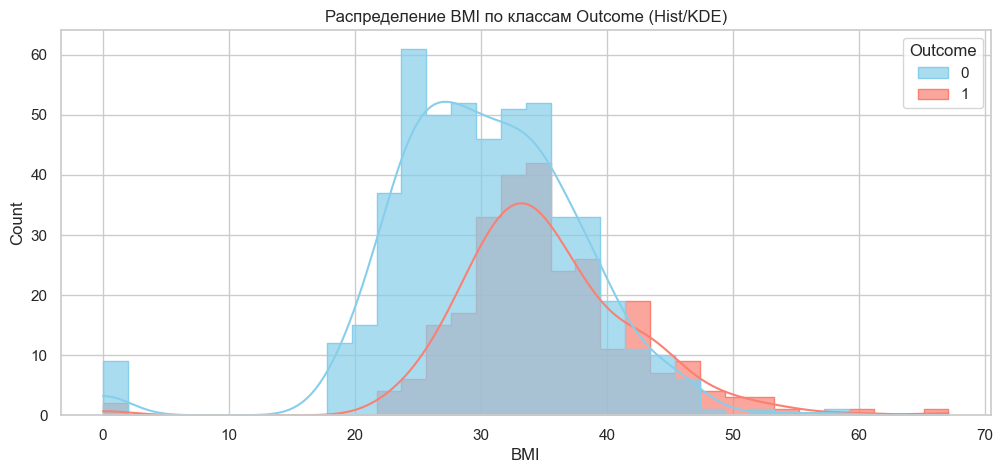


--- Сравнение распределений для: DiabetesPedigreeFunction по Outcome ---


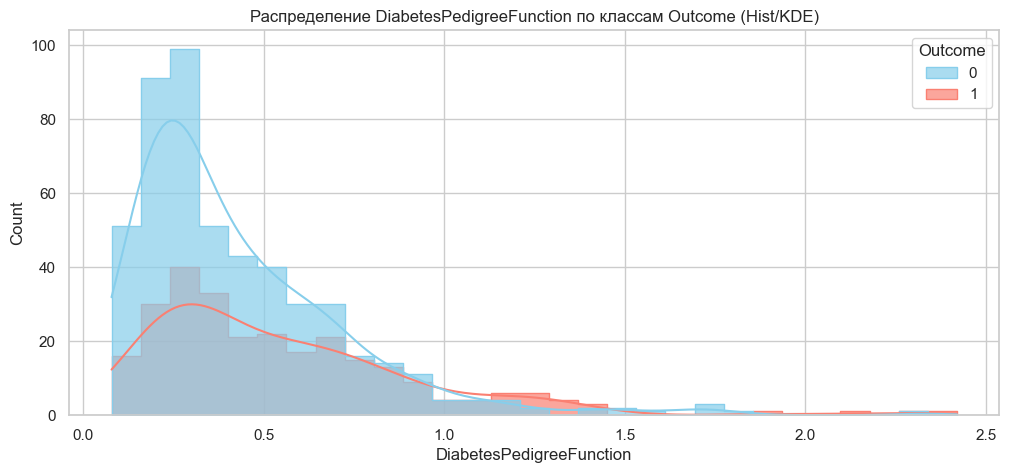


--- Сравнение распределений для: Age по Outcome ---


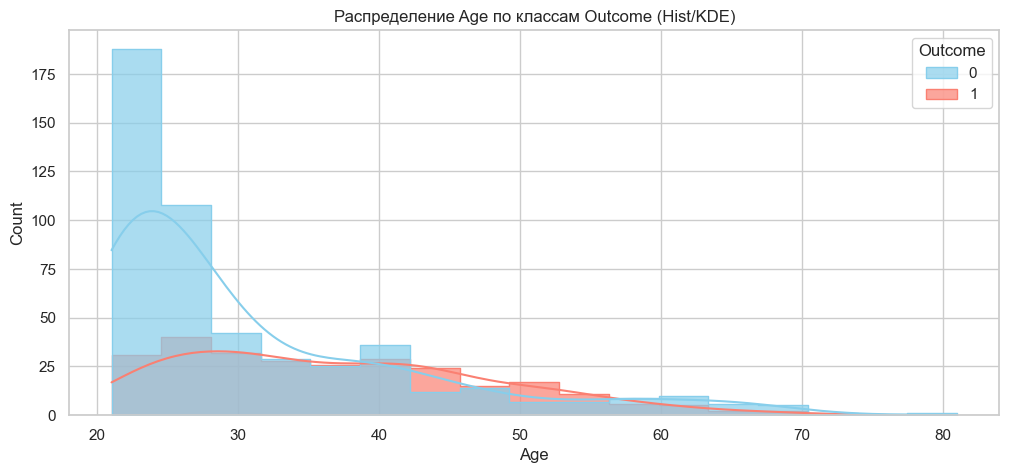

In [119]:
print(f"\n6. Сравнение распределений признаков по классам целевого признака '{TARGET_COLUMN}':")

for col in feature_columns:
    print(f"\n--- Сравнение распределений для: {col} по {TARGET_COLUMN} ---")
    
    # Вариант 1: Histplot + KDE (axes-level)
    plt.figure(figsize=(12, 5))
    sns.histplot(data=df, x=col, hue=TARGET_COLUMN, kde=True, multiple="layer", palette={0: "skyblue", 1: "salmon"}, element="step", alpha=0.7)
    plt.title(f'Распределение {col} по классам {TARGET_COLUMN} (Hist/KDE)')
    plt.show()

**Удаление колонок, которые не влияют** 

In [121]:
print("\n7. Поиск колонок для потенциального удаления (по техническим причинам):")
columns_to_consider_dropping = []
for col in df.columns:
    if df[col].nunique(dropna=False) == 1:
        print(f"Колонка '{col}' имеет только одно уникальное значение. Кандидат на удаление.")
        if col not in columns_to_consider_dropping:
            columns_to_consider_dropping.append(col)

if not columns_to_consider_dropping:
    print("Не найдено колонок с одним уникальным значением.")
else:
    print(f"Колонки, состоящие из одного значения: {columns_to_consider_dropping}")

df_cleaned = df.copy()
print("\nEDA завершен. DataFrame 'df_cleaned' (с NaN вместо нулей) готов для дальнейшей предобработки.")
print(f"Размер итогового DataFrame: {df_cleaned.shape}")


7. Поиск колонок для потенциального удаления (по техническим причинам):
Не найдено колонок с одним уникальным значением.

EDA завершен. DataFrame 'df_cleaned' (с NaN вместо нулей) готов для дальнейшей предобработки.
Размер итогового DataFrame: (768, 9)


### Задание 1.2

Разделяем дата сет и нормализуем данные!

In [135]:
X = df.drop("Outcome", axis = 1)
y = df["Outcome"]

#Разделение данных на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nРазмер обучающей выборки X: {X_train.shape}")
print(f"Размер тестовой выборки X: {X_test.shape}")
print(f"Распределение классов в y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Распределение классов в y_test:\n{y_test.value_counts(normalize=True)}")
print (50 * '-')
# 2. Обработка пропусков (импутация)
# Будем использовать SimpleImputer для заполнения пропусков медианой
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Обучаем импьютер на обучающих данных и трансформируем их
X_train_imputed = imputer.fit_transform(X_train)
# Трансформируем тестовые данные, используя обученный импьютер
X_test_imputed = imputer.transform(X_test)

# Преобразуем обратно в DataFrame для удобства (сохраняя имена колонок)
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

print("\nПроверка пропусков после импутации в X_train_imputed_df:")
print(X_train_imputed_df.isnull().sum().sum()) # Должно быть 0
print("Проверка пропусков после импутации в X_test_imputed_df:")
print(X_test_imputed_df.isnull().sum().sum())   # Должно быть 0

# 3. Нормализация данных с использованием StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Обучаем скейлер на импутированных обучающих данных и трансформируем их
X_train_scaled = scaler.fit_transform(X_train_imputed_df)
# Трансформируем импутированные тестовые данные, используя обученный скейлер
X_test_scaled = scaler.transform(X_test_imputed_df)

# Преобразуем обратно в DataFrame для наглядности (хотя для моделей это не обязательно)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nПервые 5 строк отмасштабированных обучающих данных:")
print(X_train_scaled_df.head())


Размер обучающей выборки X: (614, 8)
Размер тестовой выборки X: (154, 8)
Распределение классов в y_train:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64
Распределение классов в y_test:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64
--------------------------------------------------

Проверка пропусков после импутации в X_train_imputed_df:
0
Проверка пропусков после импутации в X_test_imputed_df:
0

Первые 5 строк отмасштабированных обучающих данных:
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
353    -0.851355 -0.980131      -0.404784      -0.553973 -0.331319 -0.607678   
711     0.356576  0.161444       0.465368       0.392787 -0.526398 -0.302139   
373    -0.549372 -0.504474      -0.622322       1.213312  0.142444  0.372594   
46     -0.851355  0.795653      -0.731091      -1.311380 -0.730766 -0.289408   
682    -1.153338 -0.821579      -0.296015       1.150195  0.244628  1.607482   

     DiabetesPedigre

Пропусков нету

# Задание 2. Создание модели и обучение

Выбор моделей: Gaussian Naive Bayes, LogReg, SVM - SVC

In [168]:
# Словарь для хранения лучших моделей и их результатов
best_models = {}
model_results = {}

# --- Модель 1: Логистическая регрессия ---
print("\nМодель 1: Логистическая регрессия")
log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'], # saga поддерживает l1 и l2, liblinear l1 и l2
    'penalty': ['l1', 'l2']
}
# Уменьшим количество итераций для saga, чтобы не было предупреждений о сходимости
# Также можно увеличить max_iter, если необходимо
log_reg = LogisticRegression(random_state=42, max_iter=200) # Увеличил max_iter
grid_log_reg = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_log_reg.fit(X_train_scaled, y_train)

best_log_reg = grid_log_reg.best_estimator_
best_models['LogisticRegression'] = best_log_reg
print(f"Лучшие параметры для LogisticRegression: {grid_log_reg.best_params_}")

# --- Модель 2: Метод опорных векторов (SVC) ---
print("\nМодель 2: Метод опорных векторов (SVC)")
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01] # Добавил 0.01 для rbf
}
svc = SVC(random_state=42, probability=True) # probability=True если понадобится predict_proba
grid_svc = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_svc.fit(X_train_scaled, y_train)

best_svc = grid_svc.best_estimator_
best_models['SVC'] = best_svc
print(f"Лучшие параметры для SVC: {grid_svc.best_params_}")

# --- Модель 3: Дерево решений (DecisionTreeClassifier) --- <--- НОВАЯ МОДЕЛЬ
print("\nМодель 3.0: Дерево решений (DecisionTreeClassifier)")
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15], # None означает, что узлы расширяются, пока все листья не станут чистыми или пока все листья не будут содержать менее min_samples_split выборок.
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced'] # Добавим параметр для борьбы с дисбалансом
}
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, dt_params, cv=5, scoring='f1_weighted', n_jobs=-1) # Изменим scoring на f1_weighted
grid_dt.fit(X_train_scaled, y_train)

best_dt = grid_dt.best_estimator_
best_models['DecisionTree'] = best_dt
print(f"Лучшие параметры для DecisionTree: {grid_dt.best_params_}")


# --- Модель 3: Случайный лес (RandomForestClassifier) ---
# DecisionTree часто используется как часть RandomForest, поэтому выберем RandomForest.
# Если нужна именно DecisionTree отдельно, можно добавить.
print("\nМодель 3.1: Случайный лес (RandomForestClassifier)")
rf_params = {
    'n_estimators': [50, 100], # Уменьшил для скорости
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
best_models['RandomForest'] = best_rf
print(f"Лучшие параметры для RandomForest: {grid_rf.best_params_}")

# (Опционально) Модель Naive Bayes (GaussianNB)
# GaussianNB обычно не требует сложного подбора гиперпараметров через GridSearchCV,
# но можно проверить 'var_smoothing'.
print("\nМодель 4 : Наивный Байес (GaussianNB)")
gnb_params = {'var_smoothing': np.logspace(0,-9, num=10)} # Небольшой диапазон для var_smoothing
gnb = GaussianNB()
grid_gnb = GridSearchCV(gnb, gnb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_gnb.fit(X_train_scaled, y_train)

best_gnb = grid_gnb.best_estimator_
best_models['GaussianNB'] = best_gnb
print(f"Лучшие параметры для GaussianNB: {grid_gnb.best_params_}")


Модель 1: Логистическая регрессия
Лучшие параметры для LogisticRegression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Модель 2: Метод опорных векторов (SVC)
Лучшие параметры для SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Модель 3.0: Дерево решений (DecisionTreeClassifier)
Лучшие параметры для DecisionTree: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}

Модель 3.1: Случайный лес (RandomForestClassifier)
Лучшие параметры для RandomForest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Модель 4 : Наивный Байес (GaussianNB)
Лучшие параметры для GaussianNB: {'var_smoothing': 0.01}


# Задание 3. Оценка

In [172]:
print("\n--- Задание 3: Оценка качества моделей ---")
for model_name, model in best_models.items():
    print(f"\n--- Оценка модели: {model_name} ---")
    
    y_pred_test = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    # Для бинарной классификации важно смотреть на precision/recall/f1 для позитивного класса (1 - диабет)
    # или использовать 'weighted'/'macro' average для общего представления.
    # В classification_report будут все детали.
    precision_macro = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    
    f1_positive_class = f1_score(y_test, y_pred_test, pos_label=1, zero_division=0) # F1 для класса "Диабет"
    
    report = classification_report(y_test, y_pred_test, target_names=['Нет диабета (0)', 'Диабет (1)'], zero_division=0)
    
    model_results[model_name] = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_positive_class': f1_positive_class,
        'classification_report': report
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro Avg): {precision_macro:.4f}")
    print(f"Recall (Macro Avg): {recall_macro:.4f}")
    print(f"F1-score (Macro Avg): {f1_macro:.4f}")
    print(f"F1-score (Диабет (1)): {f1_positive_class:.4f}") # Важно для миноритарного класса
    print("\nClassification Report:")
    print(report)
    
    if accuracy > 0.70:
        print(f"Модель {model_name} ПРОШЛА порог accuracy > 70%.")
        if accuracy > 0.80:
            print(f"Модель {model_name} также ПРОШЛА желаемый порог accuracy > 80%.")
    else:
        print(f"Модель {model_name} НЕ ПРОШЛА порог accuracy > 70%.")

# --- Интерпретация результатов и выводы ---
print("\n\n--- Интерпретация результатов и выводы ---")

print("\nСводка метрик по моделям:")
results_summary_df = pd.DataFrame(index=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_positive_class'])
for model_name, metrics in model_results.items():
    results_summary_df[model_name] = [
        metrics['accuracy'], 
        metrics['precision_macro'], 
        metrics['recall_macro'], 
        metrics['f1_macro'],
        metrics['f1_positive_class']
    ]
print(results_summary_df.T.sort_values(by='f1_positive_class', ascending=False)) # Сортируем по F1 для класса "Диабет"

print("\nОбщие выводы:")


--- Задание 3: Оценка качества моделей ---

--- Оценка модели: LogisticRegression ---
Accuracy: 0.7143
Precision (Macro Avg): 0.6840
Recall (Macro Avg): 0.6693
F1-score (Macro Avg): 0.6742
F1-score (Диабет (1)): 0.5600

Classification Report:
                 precision    recall  f1-score   support

Нет диабета (0)       0.76      0.82      0.79       100
     Диабет (1)       0.61      0.52      0.56        54

       accuracy                           0.71       154
      macro avg       0.68      0.67      0.67       154
   weighted avg       0.71      0.71      0.71       154

Модель LogisticRegression ПРОШЛА порог accuracy > 70%.

--- Оценка модели: SVC ---
Accuracy: 0.7208
Precision (Macro Avg): 0.6918
Recall (Macro Avg): 0.6743
F1-score (Macro Avg): 0.6800
F1-score (Диабет (1)): 0.5657

Classification Report:
                 precision    recall  f1-score   support

Нет диабета (0)       0.76      0.83      0.79       100
     Диабет (1)       0.62      0.52      0.57        54

**Есть к чему стремиться!** 

In [161]:
print("\nВозможные пути для дальнейшего улучшения:")
print("1. Более тщательный подбор гиперпараметров: расширить сетки в GridSearchCV, использовать RandomizedSearchCV для более широкого поиска.")
print("2. Feature Engineering: создание новых признаков на основе существующих (например, полиномиальные признаки, взаимодействия).")
print("3. Анализ ошибок: посмотреть, на каких примерах модели ошибаются, чтобы понять их слабые стороны.")
print("4. Более сложные модели: попробовать градиентный бустинг (XGBoost, LightGBM, CatBoost) или нейронные сети, если данных достаточно.")
print("5. Альтернативные методы импутации пропусков: KNNImputer или итеративные импьютеры.")
print("6. Работа с несбалансированностью классов (если это проблема): методы oversampling (SMOTE), undersampling, или использование метрик, более устойчивых к дисбалансу, при оптимизации.")
print("7. Более глубокий анализ важности признаков для отбора наиболее значимых или для лучшего понимания модели.")


Возможные пути для дальнейшего улучшения:
1. Более тщательный подбор гиперпараметров: расширить сетки в GridSearchCV, использовать RandomizedSearchCV для более широкого поиска.
2. Feature Engineering: создание новых признаков на основе существующих (например, полиномиальные признаки, взаимодействия).
3. Анализ ошибок: посмотреть, на каких примерах модели ошибаются, чтобы понять их слабые стороны.
4. Более сложные модели: попробовать градиентный бустинг (XGBoost, LightGBM, CatBoost) или нейронные сети, если данных достаточно.
5. Альтернативные методы импутации пропусков: KNNImputer или итеративные импьютеры.
6. Работа с несбалансированностью классов (если это проблема): методы oversampling (SMOTE), undersampling, или использование метрик, более устойчивых к дисбалансу, при оптимизации.
7. Более глубокий анализ важности признаков для отбора наиболее значимых или для лучшего понимания модели.


Можно попробовать использовать GBDT

**ТЕСТ**